# Weight By Portfolio Strategy

Basic buy and hold that allows weighting by user specified weights, Equal, Sharpe Ratio, Annual Returns, Std Dev, Vola, or DS Vola.  

Rebalance is yearly, monthly, weekly, or daily.  Option to sell all shares of an investment is regime turns negative.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

import pinkfish as pf
import strategy

# Format price data.
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots.
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
# Symbol Lists.
SP500_Sectors = \
    {'XLB': None, 'XLE': None, 'XLF': None, 'XLI': None,
     'XLK': None, 'XLP': None, 'XLU': None, 'XLV': None, 'XLY': None}

Mixed_Asset_Classes = \
    {'IWB': None, 'SPY': None, 'VGK': None, 'IEV': None,
     'EWJ': None, 'EPP': None, 'IEF': None, 'SHY': None, 'GLD': None}
FANG_Stocks = \
    {'FB': None, 'AMZN': None, 'NFLX': None, 'GOOG': None}

Stocks_Bonds_Gold = \
    {'SPY': None, 'QQQ': None, 'TLT': None, 'GLD': None}

Stocks_Bonds = \
    {'SPY': 0.50, 'AGG': 0.50}

# Pick one of the above.
weights = Stocks_Bonds_Gold
symbols = list(weights)

capital = 100_000
start = datetime.datetime(*pf.ALPHA_BEGIN)
#start = datetime.datetime(*pf.SP500_BEGIN)
end = datetime.datetime.now()

In [4]:
weight_by_choices = ('equal', 'sharpe', 'ret', 'sd', 'vola', 'ds_vola')
rebalance_choices = ('yearly', 'monthly', 'weekly', 'daily')

options = {
    'use_adj'           : True,
    'use_cache'         : True,
    'margin'            : 1,
    'weights'           : weights,
    'weight_by'         : 'vola',
    'rebalance'         : 'monthly',
    'use_regime_filter' : False
}

Run Strategy

In [5]:
s = strategy.Strategy(symbols, capital, start, end, options=options)
s.run()

2007-11-20 SPY:20.2 TLT:50.0 QQQ:14.8 GLD:14.9 cash:  0.1 total: 100.0
2007-12-03 SPY:19.4 TLT:46.6 QQQ:16.2 GLD:17.7 cash:  0.1 total: 100.0
2008-01-02 SPY:18.9 TLT:28.3 QQQ:23.2 GLD:21.5 cash:  8.1 total: 100.0
2008-02-01 SPY:21.7 TLT:34.0 QQQ:18.1 GLD:24.9 cash:  1.3 total: 100.0
2008-03-03 SPY:22.1 TLT:26.8 QQQ:21.7 GLD:24.5 cash:  4.9 total: 100.0
2008-04-01 SPY:21.8 TLT:33.0 QQQ:18.8 GLD:21.3 cash:  5.1 total: 100.0
2008-05-01 SPY:25.6 TLT:34.1 QQQ:16.7 GLD:18.3 cash:  5.4 total: 100.0
2008-06-02 SPY:26.7 TLT:36.0 QQQ:18.1 GLD:15.9 cash:  3.3 total: 100.0
2008-07-01 SPY:22.9 TLT:42.8 QQQ:16.3 GLD:17.9 cash:  0.1 total: 100.0
2008-08-01 SPY:20.8 TLT:37.0 QQQ:19.0 GLD:23.1 cash:  0.2 total: 100.0
2008-09-02 SPY:21.4 TLT:38.5 QQQ:19.4 GLD:15.4 cash:  5.4 total: 100.0
2008-10-01 SPY:20.1 TLT:41.2 QQQ:21.1 GLD:17.4 cash:  0.2 total: 100.0
2008-11-03 SPY: 9.5 TLT:54.8 QQQ:10.9 GLD:19.5 cash:  5.2 total: 100.0
2008-12-01 SPY:12.3 TLT:40.6 QQQ:18.4 GLD:24.9 cash:  3.8 total: 100.0
2009-0

View log DataFrames: raw trade log, trade log, and daily balance.

In [6]:
s.rlog.head()

,date,seq_num,price,shares,entry_exit,direction,symbol
0,2007-11-20,0,105.57,191,entry,LONG,SPY
0,2007-11-20,1,58.43,856,entry,LONG,TLT
0,2007-11-20,2,43.42,340,entry,LONG,QQQ
0,2007-11-20,3,79.47,188,entry,LONG,GLD
1,2007-12-03,4,107.79,8,exit,LONG,SPY


In [7]:
s.tlog.tail()

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
172,2023-11-01,420.95,2023-12-20,468.26,47.31,3406.08,72,352416.19,LONG,SPY
179,2023-11-01,84.56,2023-12-20,99.56,15.00,435.03,29,352851.22,LONG,TLT
176,2023-11-01,356.25,2023-12-20,403.08,46.83,46.83,1,352898.06,LONG,QQQ
173,2023-12-01,457.25,2023-12-20,468.26,11.01,231.29,21,353129.35,LONG,SPY
177,2023-12-01,389.16,2023-12-20,403.08,13.92,1002.05,72,354131.39,LONG,QQQ


In [8]:
s.dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2023-12-14,455783.57,455783.57,455783.57,1954,11186.10,1.00,-
2023-12-15,455094.61,455094.61,455094.61,1954,11186.10,1.00,-
2023-12-18,456490.78,456490.78,456490.78,1954,11186.10,1.00,-
2023-12-19,459125.28,459125.28,459125.28,1954,11186.10,1.00,-
2023-12-20,454131.39,454131.39,454131.39,0,454131.39,1.00,X


Generate strategy stats - display all available stats.

In [9]:
pf.print_full(s.stats)

start                                                  2007-11-20
end                                                    2023-12-20
beginning_balance                                          100000
ending_balance                                          454131.39
total_net_profit                                        354131.39
gross_profit                                            459712.17
gross_loss                                             -105580.78
profit_factor                                                4.35
return_on_initial_capital                                  354.13
annual_return_rate                                           9.87
trading_period                           16 years 1 months 0 days
pct_time_in_market                                         100.00
margin                                                          1
avg_leverage                                                 1.00
max_leverage                                                 1.00
min_levera

View Performance by Symbol

,cumul_total,weight,pct_cumul_total,relative_performance
SPY,"$118,752.40",0.25,0.34,1.34
TLT,"$21,288.88",0.25,0.06,0.24
QQQ,"$149,080.54",0.25,0.42,1.68
GLD,"$65,009.57",0.25,0.18,0.73
TOTAL,"$354,131.39",1.00,1.00,1.00


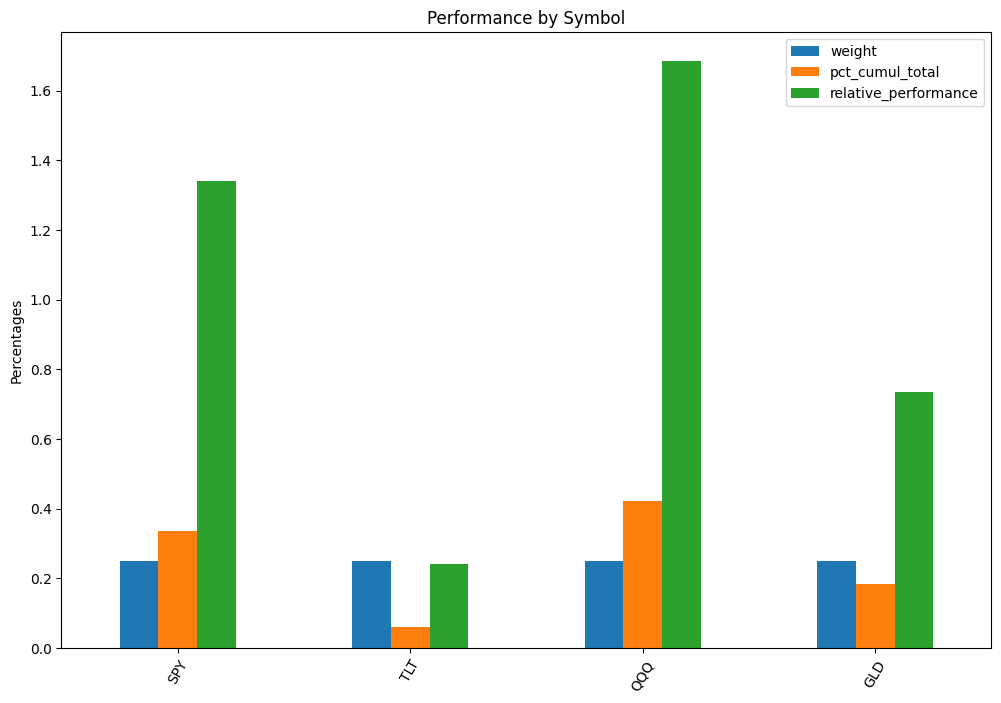

In [10]:
symbols_no_weights = [k for k,v in weights.items() if v is None]
symbols_weights    = {k:v for k,v in weights.items() if v is not None}
remaining_weight   = 1 - sum(symbols_weights.values())

weights_ = weights.copy()
for symbol in symbols_no_weights:
    weights_[symbol] = (1 / len(symbols_no_weights)) * remaining_weight
totals = s.portfolio.performance_per_symbol(weights=weights_)
totals

,SPY,TLT,QQQ,GLD
SPY,1.00,-0.35,0.92,0.04
TLT,-0.35,1.00,-0.29,0.18
QQQ,0.92,-0.29,1.00,0.02
GLD,0.04,0.18,0.02,1.00


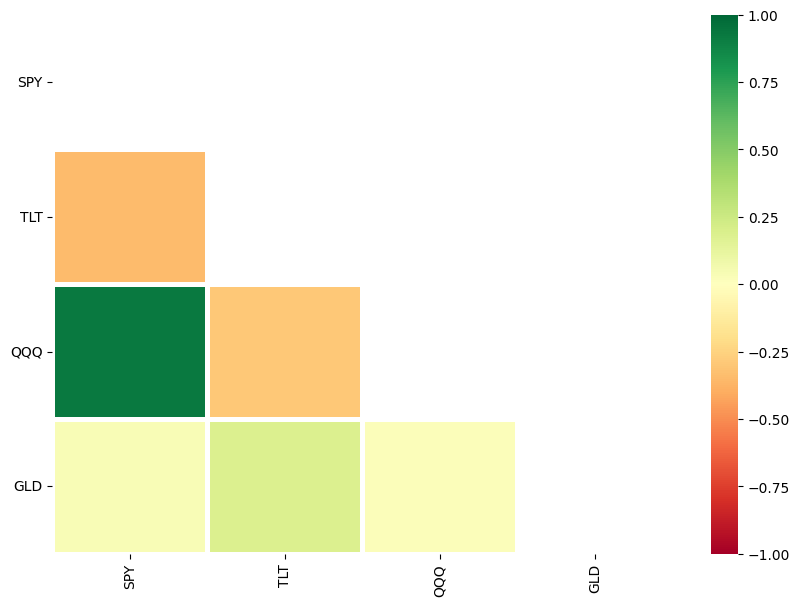

In [11]:
corr_df = s.portfolio.correlation_map(s.ts)
corr_df

Run Benchmark, Retrieve benchmark logs, and Generate benchmark stats.

In [12]:
benchmark = pf.Benchmark('SPY', s.capital, s.start, s.end, use_adj=True)
benchmark.run()

Plot Equity Curves: Strategy vs Benchmark

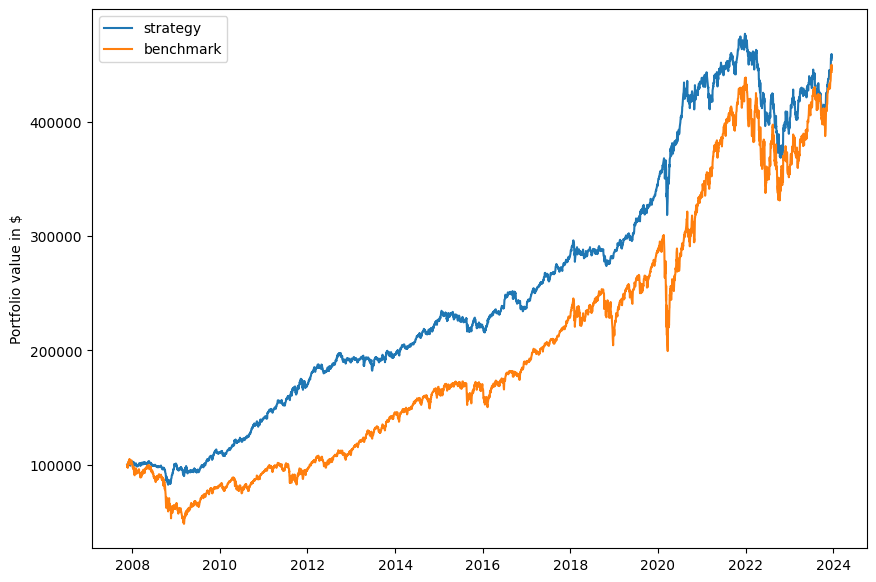

In [13]:
pf.plot_equity_curve(s.dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,9.87,9.70
max_closed_out_drawdown,-22.73,-53.88
annualized_return_over_max_drawdown,0.43,0.18
best_month,19.23,23.61
worst_month,-13.56,-30.98
sharpe_ratio,1.02,0.56
sortino_ratio,1.41,0.68
monthly_std,2.84,4.83
annual_std,11.30,16.58


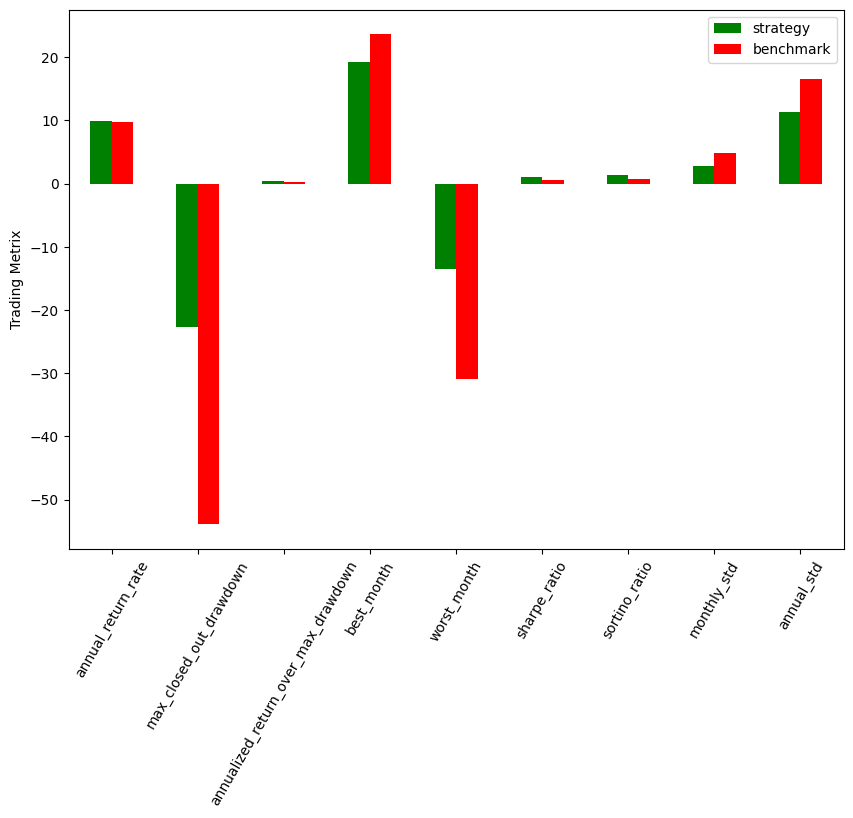

In [14]:
df = pf.plot_bar_graph(s.stats, benchmark.stats)
df

Analysis: Kelly Criterian

In [15]:
kelly = pf.kelly_criterion(s.stats, benchmark.stats)
kelly

sharpe_ratio            1.02
sharpe_ratio_max        1.07
sharpe_ratio_min        0.96
strategy risk           0.11
instrument risk         0.17
optimal target risk     1.02
half kelly criterion    0.51
aggressive leverage     6.13
moderate leverage       3.07
conservative leverage   2.89
dtype: float64